# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [ ]:
data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
data = data.fillna('')
data.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [ ]:
train.value_counts('target')

target
0    3024
1    2305
dtype: int64

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [ ]:
popular_keywords = train['keyword'].value_counts()[1:11].index.to_list()
popular_keywords

['damage',
 'siren',
 'wreckage',
 'fatalities',
 'deluge',
 'refugees',
 'derail',
 'fear',
 'tsunami',
 'fatality']

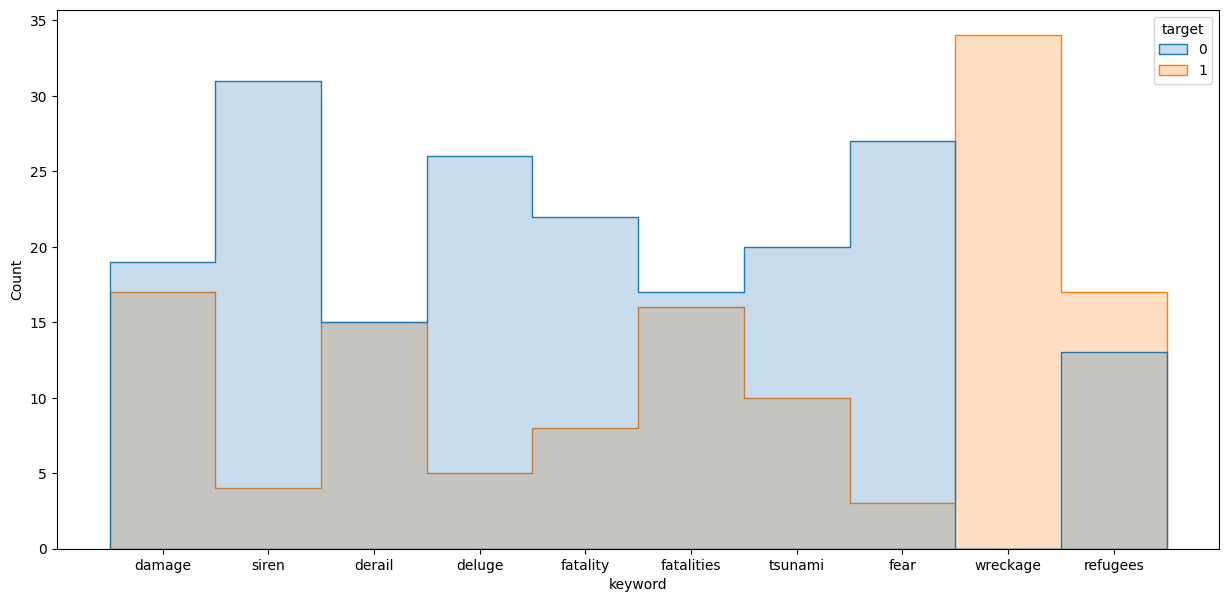

In [ ]:
plt.figure(figsize=(15,7))
for_plot = train.loc[train['keyword']. isin(popular_keywords)]
sns.histplot(for_plot, x = "keyword", hue = "target", element = "step")
plt.show()

**Выводы**: в обучающей выборке преобладают объекты 0 класса(твиты про ненастоящие катастрофы) - это заметно и по распределению классов, и по диаграмме(голубая линия в для 80% ключевых слов выше). Однако есть ключевые слова(wreckage, refugees), у которых большинство объектов или все объекты относятся к 1 классу.

## Задание 3 (0.5 балла)

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [ ]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [ ]:
train_new = train.drop(columns='id')
train_new.text = train_new.keyword + ' ' + train_new.location + ' ' + train_new.text
train_new = train_new.drop(columns=['keyword', 'location'])

In [ ]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


In [ ]:
test_new = test.drop(columns='id')
test_new.text = test_new.keyword + ' ' + test_new.location + ' ' + test_new.text
test_new = test_new.drop(columns=['keyword', 'location'])

## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(train_new['text'])

X.shape

(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось?

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [ ]:
def contains_digit(s: str) -> bool:
    return any(ch.isdigit() for ch in s)

def contains_punctuation(s: str) -> bool:
    return any(ch in punctuation for ch in s)

def is_hashtag(s: str) -> bool:
    return s[0] == '#'

def is_mention(s: str) -> bool:
    return s[0] == '@'

def investigate_vocabulary(vocabulary):
    digits = 0
    punc = 0
    hashtag = 0
    mention = 0
    for word in vocabulary:
      digits += contains_digit(word)
      punc += contains_punctuation(word)
      hashtag += is_hashtag(word)
      mention += is_mention(word)
    print('With digit:      ', digits
          )
    print('With punctuation:', punc
          )
    print('Hashtags:        ', hashtag
          )
    print('Mentions:        ', mention
          )




In [ ]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [ ]:
investigate_vocabulary(cnt_vec.vocabulary_.keys())

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [ ]:
from nltk.tokenize import TweetTokenizer

cv_tweet = CountVectorizer(tokenizer=TweetTokenizer().tokenize)
X = cv_tweet.fit_transform(train_new['text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
investigate_vocabulary(cv_tweet.vocabulary_.keys())

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** при использовании токенизатора стало заметно больше самих слов в словаре. Токенизатор позволяет отличать хэштеги и упоминания(без него их было как будто 0) - для анализа твитов это большой плюс, а также точнее разделяет слова(заметно по увеличению слов с цифрами и пунктуацией).

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно:

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [ ]:
import nltk

In [ ]:
nltk.download("stopwords", quiet=True)

True

In [ ]:
def contains_only_latin_letters(s: str) -> bool:
    return all((ch >= 'a') and (ch <= 'z') for ch in s)

def is_emoji(s: str) -> bool:
    return any(ch in "()" for ch in s) and all(ch in punctuation for ch in s)

def is_hashtag(s: str) -> bool:
    return s[0] == '#' and contains_only_latin_letters(s[1:])

def custom_tokenizer(s: str) -> List[str]:
    s = s.lower()
    tw = TweetTokenizer()
    tokens = tw.tokenize(s)
    new_tokens = [t for t in tokens if contains_only_latin_letters(t) or is_emoji(t) or is_hashtag(t)]
    from nltk.corpus import stopwords
    tokens = [t for t in new_tokens if not (t in stopwords.words("english"))]
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer("english")
    stemmed = [stemmer.stem(t) for t in tokens]
    return stemmed


In [ ]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [ ]:
train_new['text'][:10].apply(lambda x: custom_tokenizer(x))

1186    [bridg, ash, australia, collaps, trent, bridg,...
4071    [hail, carol, stream, illinoi, great, michigan...
5461    [polic, houston, cnn, tennesse, movi, theater,...
5787        [riot, still, riot, coupl, hour, left, class]
7445    [wound, lake, highland, crack, path, wipe, mor...
151     [airplan, somewher, expert, franc, begin, exam...
915     [bloodi, isol, citi, world, perth, came, kill,...
1305                    [burn, except, idk, realli, burn]
2570                  [destroy, (, ask, ), destroy, hous]
7399    [wound, maracay, nirgua, venezuela, polic, off...
Name: text, dtype: object

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [ ]:
vectorizer = CountVectorizer(tokenizer = custom_tokenizer)
vectorizer.fit(train_new['text'])
X_train = vectorizer.transform(train_new['text'])
X_test = vectorizer.transform(test_new['text'])

2. Обучите LogisticRegression на полученных признаках.


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, train_new['target'])
pred = clf.predict(X_test)

3. Посчитайте метрику f1-score на тестовых данных.

In [ ]:
from sklearn.metrics import f1_score

print('F1 score:', f1_score(test_new['target'], pred))

F1 score: 0.752953813104189


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer()
X_train = tfidf_vec.fit_transform(train_new['text'])
X_test = tfidf_vec.transform(test_new['text'])

clf = LogisticRegression()
clf.fit(X_train, train_new['target'])
pred = clf.predict(X_test)

print('F1 score:', f1_score(test_new['target'], pred))

F1 score: 0.7495872317006055


In [ ]:
X_train_1 = X_train

1. **Ответ:** качество относительно не изменилось


2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [ ]:
# 2
tfidf_vec = TfidfVectorizer(max_df = 0.9)
X_train = tfidf_vec.fit_transform(train_new['text'])
X_test = tfidf_vec.transform(test_new['text'])

clf = LogisticRegression()
clf.fit(X_train, train_new['target'])
pred = clf.predict(X_test)

print('F1 score:', f1_score(test_new['target'], pred))
print('Previous shape:', X_train_1.shape, 'New shape:', X_train.shape)

F1 score: 0.7495872317006055
Previous shape: (5329, 18455) New shape: (5329, 18455)


2. **Ответ:** ни мера, ни размер не поменялись, скорее всего слов, которые бы встречались в >90% нет

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества?

In [ ]:
# 3
tfidf_vec = TfidfVectorizer(min_df = 0.0001)
X_train = tfidf_vec.fit_transform(train_new['text'])
X_test = tfidf_vec.transform(test_new['text'])

clf = LogisticRegression()
clf.fit(X_train, train_new['target'])
pred = clf.predict(X_test)

print('F1 score:', f1_score(test_new['target'], pred))

F1 score: 0.7495872317006055


3. **Ответ:** качество не поменялось, возможно слов, которые встречаются так редко, тоже нет(твиты короткие, слов мало). При этом, если поставить min_df > 0.0001, то качество станет заметно хуже


## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(n_features=5000)
X_train = tfidf_vec.fit_transform(train_new['text'])
X_test = tfidf_vec.transform(test_new['text'])

clf = LogisticRegression()
clf.fit(X_train, train_new['target'])
pred = clf.predict(X_test)

print('F1 score:', f1_score(test_new['target'], pred))

F1 score: 0.7495872317006055


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** самое большое качество получилось CountVectorizer и кастомным токенизатором. Думаю, если у других векторизаторов поиграться с параметрами(стоп-слова и тд), то можно было бы получить результаты такие же или лучше, чем с собственным токенизатором.

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [ ]:
# как говорится, работает - не трогай

vectorizer = CountVectorizer(tokenizer = custom_tokenizer)
vectorizer.fit(train_new['text'])
X_train = vectorizer.transform(train_new['text'])
X_test = vectorizer.transform(test_new['text'])

clf = LogisticRegression()
clf.fit(X_train, train_new['target'])
pred = clf.predict(X_test)

print('F1 score:', f1_score(test_new['target'], pred))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.752953813104189
